<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/baseball_features_for_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# font

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# Baseball features for modeling

In [ ]:
!pip install catboost
!pip install pybaseball

<IPython.core.display.Javascript object>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 28.2 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import KFold
import catboost as cb
import pybaseball as bb

import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

In [ ]:
project_dir = 'drive/My Drive/baseball-features-for-modeling'

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv(f'{project_dir}/train.csv')
df.shape

<IPython.core.display.Javascript object>

(50000, 41)

In [ ]:
df.head()

<IPython.core.display.Javascript object>

,uid,pitch_type,release_speed,release_pos_x,release_pos_z,game_type,is_lhp,is_lhb,balls,strikes,...,release_extension,release_pos_y,pitch_number,pitch_name,spin_axis,spray_angle,bat_speed,swing_length,outcome,outcome_code
0,0,FF,93.3,2.01,5.77,R,1,0,0,0,...,6.7,53.80,1,4-Seam Fastball,136,32.304361,76.26113,7.97873,out,0
1,1,SL,86.1,2.00,5.84,R,1,1,1,2,...,6.6,53.87,4,Slider,126,14.241746,61.82557,7.87052,out,0
2,2,SI,92.7,-1.67,6.54,R,0,0,1,1,...,6.9,53.61,3,Sinker,209,-2.398097,69.42584,6.47008,single,1
3,3,FF,92.7,1.97,5.78,R,1,0,2,1,...,6.6,53.85,4,4-Seam Fastball,142,-4.906157,76.19749,8.03785,out,0
4,5,SL,85.7,2.13,5.80,R,1,0,0,2,...,6.7,53.83,3,Slider,313,35.167845,68.84496,6.37508,single,1


## Seam-shifted wake

Since the ball in baseball is not a perfect sphere, and the conditions it is being thrown in are not perfect vacuum physics, expecting perfect-sphere physics is a confound when discussing the projectile motion of a pitch. "Seam-shifted wake" can help decipher some of the error attributed to predicting projectile motion in baseball.  

There are two ways to estimate the effects of seam-shifted wake (SSW) -- by estimated vs actual spin axis and also by estimated vs actual pitch break.  

https://www.drivelinebaseball.com/2020/11/more-than-what-it-seams-an-introduction-to-seam-shifted-wakes-and-their-effect-on-sinkers/

### Method 1: Estimating spin axis  
Given the break (`pfx_x` and `pfx_z`), what was the estimated spin axis?   

This is a straightforward regressor model with very few features  

In [ ]:
df.columns.values

<IPython.core.display.Javascript object>

array(['uid', 'pitch_type', 'release_speed', 'release_pos_x',
       'release_pos_z', 'game_type', 'is_lhp', 'is_lhb', 'balls',
       'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'is_top',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'release_pos_y', 'pitch_number', 'pitch_name', 'spin_axis',
       'spray_angle', 'bat_speed', 'swing_length', 'outcome',
       'outcome_code'], dtype=object)

Spin axis is dependent on handedness -- whether the pitcher is throwing with their left hand or their right hand. The spin axis is measure in degrees and the histogram of spin axis shows seemingly 4 distributions.

<IPython.core.display.Javascript object>

,spin_axis
count,50000.000000
mean,176.567040
std,70.291032
min,-1.000000
25%,130.000000
50%,200.000000
75%,224.000000
max,359.000000


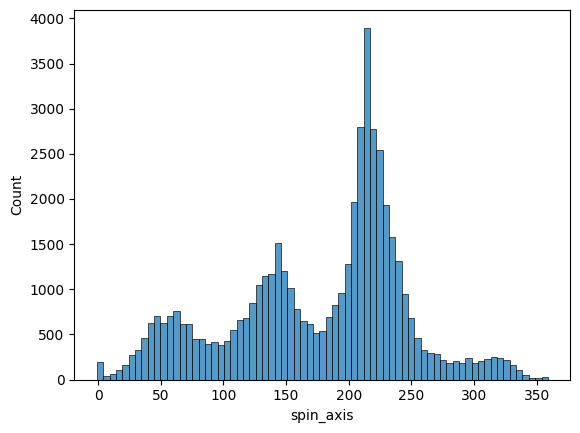

In [ ]:
sns.histplot(df['spin_axis'])
df['spin_axis'].describe()

We can demonstrate the effect of pitcher handedness by plotting two different histograms:

<IPython.core.display.Javascript object>

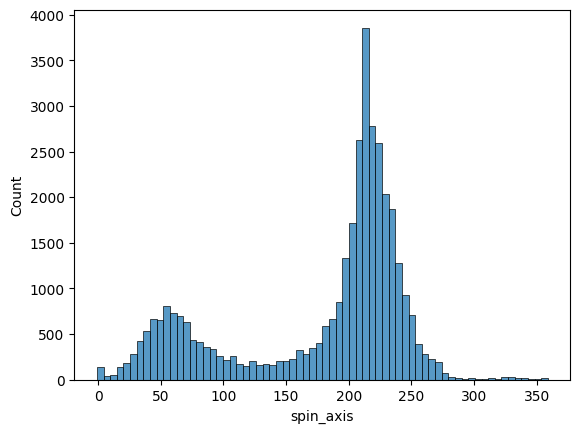

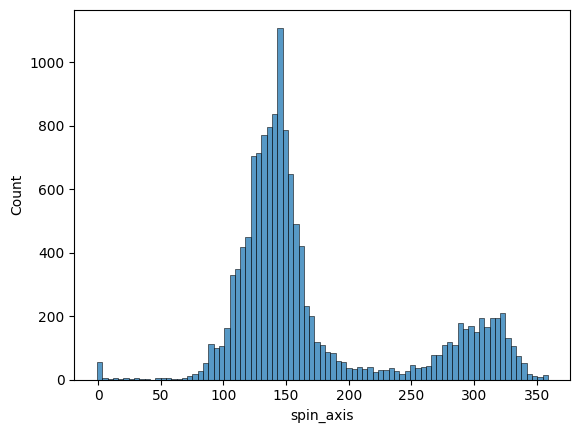

In [ ]:
sns.histplot(df.loc[df['is_lhp']==0,'spin_axis'])
plt.show()

sns.histplot(df.loc[df['is_lhp']==1,'spin_axis'])
plt.show()

The two histograms above indicate right-handed pitchers throwing pitches with spin axes about 50 degrees and 225 degrees, whereas left-handed pitchers throw pitches with spin axes about 140 degrees and 325 degrees. We can further separate the remaining bimodal distribution by plotting the distributions of each pitch type:

<IPython.core.display.Javascript object>

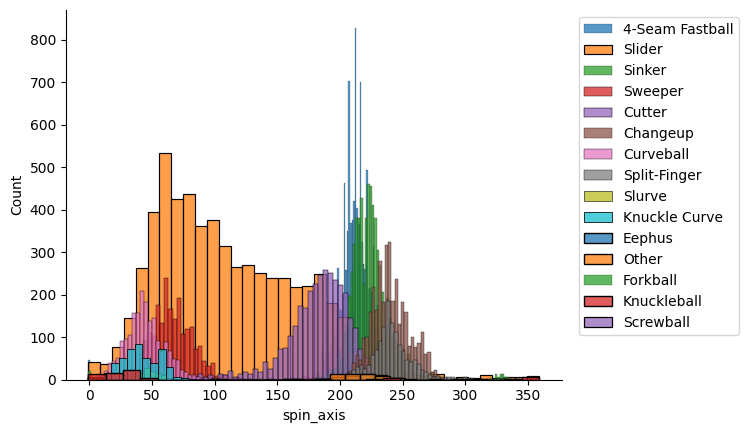

In [ ]:
for pt in df['pitch_name'].unique():
  if pt == 'Sider':
    continue
  sns.histplot(df.loc[(df['is_lhp']==0) & (df['pitch_name']==pt),'spin_axis'],label=pt)

plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()

4-seam fastballs, sinkers, change ups, splitters, and cutters tend to represent the distribution about 225 degrees while sweepers, curveballs, knuckle curves, and slurves are representing the distribution about 50 degrees. The slider, which showcases a very wide distribution across all seemingly spin axes, is unique due to the difficult-to-capture spin axis (you can read more about spin axis on MLB's glossary page or via several different baseball websites).  

<IPython.core.display.Javascript object>

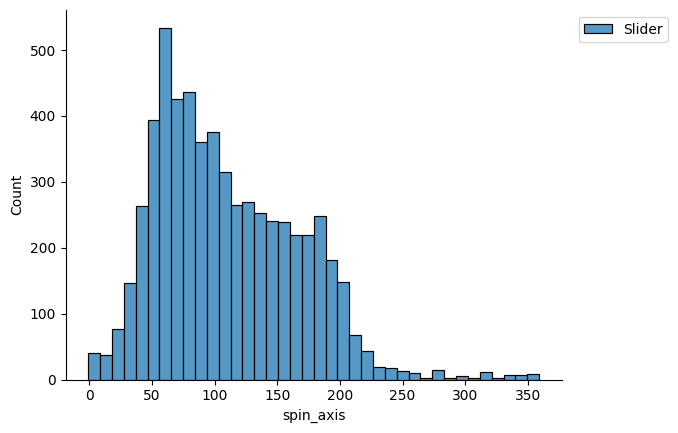

In [ ]:
for pt in df['pitch_name'].unique():
  if pt != 'Slider':
    continue
  sns.histplot(df.loc[(df['is_lhp']==0) & (df['pitch_name']==pt),'spin_axis'],label=pt)

plt.legend(bbox_to_anchor=(1.02,1), loc=2)
sns.despine()
plt.show()

I invert left-handed spin axis to mimic right-handed spin axis for modeling purposes. I demonstrate the differences below:  

In [ ]:
# Flip horizontal break for lefties
df['pfx_x_adj'] = df['pfx_x'].copy()
df.loc[df['is_lhp']==1,'pfx_x_adj'] = df.loc[df['is_lhp']==1,'pfx_x_adj'].mul(-1)

# Flip spin axis so it is reflected the same for lefties and righties
df['spin_axis_adj'] = df['spin_axis'].copy()
df.loc[df['is_lhp']==1,'spin_axis_adj'] = df.loc[df['is_lhp']==1,'spin_axis_adj'].mul(-1)
df.loc[df['is_lhp']==1,'spin_axis_adj'] = df.loc[df['is_lhp']==1,'spin_axis_adj'].add(360)
df.loc[df['is_lhp']==1,'spin_axis_adj'] = df.loc[df['is_lhp']==1,'spin_axis_adj'].replace(360,0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Axes: xlabel='spin_axis', ylabel='Count'>

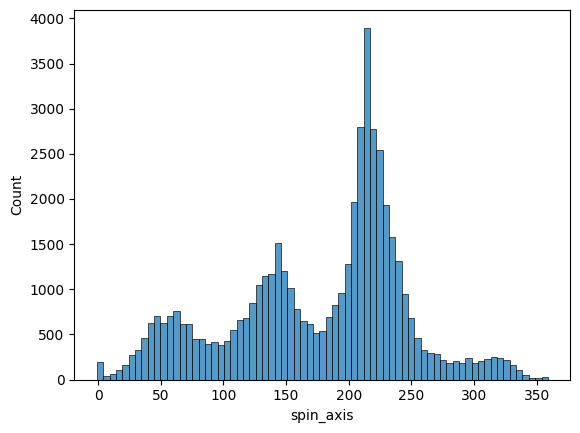

In [ ]:
sns.histplot(df['spin_axis'],label='R')


<IPython.core.display.Javascript object>

<Axes: xlabel='spin_axis_adj', ylabel='Count'>

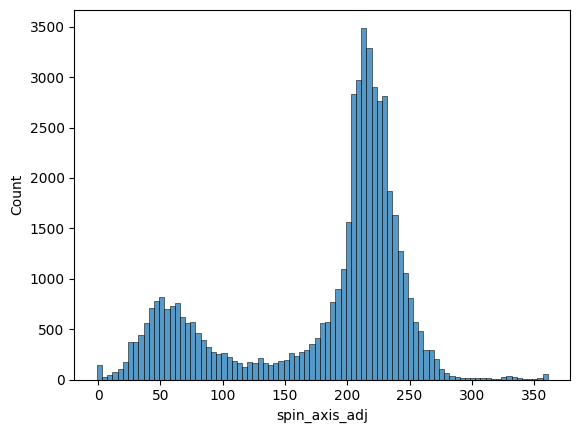

In [ ]:
sns.histplot(df['spin_axis_adj'],label='R')


Predicting spin axis based off of pitch break allows us to take the residual and use the residual as a way to explain any errors due to pitch flight. This can help explain the quality of a given pitch (think: "stuff" models). Knowing more about the quality (or difficulty) of a pitch allows us to predict the quality of a hit more precisely.

In [ ]:
feats = [
    'pfx_x_adj', 'pfx_z', 'release_spin_rate'
]
target = 'spin_axis_adj'

model_data = df.dropna(subset=feats+[target])

folds = 3
kf = KFold(folds, shuffle=True)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(verbose=False, n_estimators=300)
  model.fit(train.loc[:, feats], train[target])
  _s = pd.Series(model.predict(test.loc[:, feats]), index=test.index)
  s = pd.concat([s,_s])
model_data[f'{target}_cb'] = s

<IPython.core.display.Javascript object>

<ipython-input-33-980d808572a3>:17: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s,_s])


After predicting axis, we can show how correlated the prediction is to the target. We can get the residual by subtracting the target by the prediction. Finally, we can plot the differences in spin axis residual (known as seam-shifted wake spin axis, or `ssw_axis`) as it pertains to the break of a pitch.

<IPython.core.display.Javascript object>

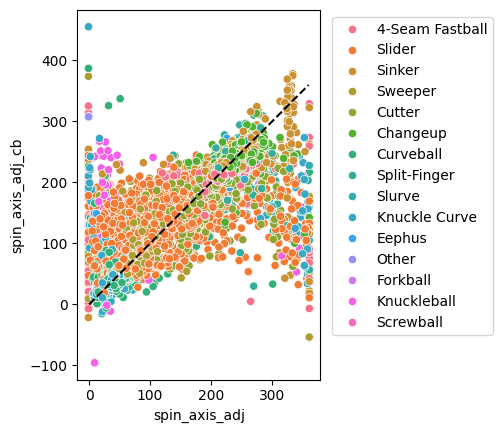

In [ ]:
fig = sns.scatterplot(data=model_data, x=target, y=f'{target}_cb', hue='pitch_name')
plt.plot([0,360],[0,360],'k--')
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
plt.show()

In [ ]:
model_data['ssw_axis'] = model_data[target].sub(model_data[f"{target}_cb"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

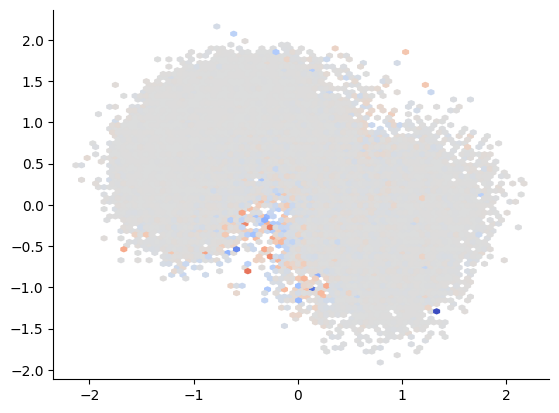

In [ ]:
gridsize = 80
cmap = sns.palettes.color_palette('coolwarm',n_colors=360*2,as_cmap=True)
plt.hexbin(data=model_data, x='pfx_x_adj', y='pfx_z',
           C='ssw_axis',gridsize=gridsize,cmap=cmap,
           vmin=-360,vmax=360)
sns.despine()
plt.show()

### Method 2. Estimate break  
Instead of estimating spin axis, you can estimate break. This uses the same methods as in method 1, except we are using spin axis and spin rate to predict break.  

In [ ]:
# Regular version
feats = ['spin_axis_adj', 'release_spin_rate']
targets = [
    'pfx_x_adj', 'pfx_z'
]


folds = 3
kf = KFold(folds, shuffle=True)
s = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(verbose=False, n_estimators=300,
                               loss_function='MultiRMSE')
  model.fit(train.loc[:, feats], train[targets])
  _s = pd.DataFrame(model.predict(test.loc[:, feats]), index=test.index, columns=targets)
  s = pd.concat([s,_s])

for target in targets:
  model_data[f'{target}_cb'] = s[target]

<IPython.core.display.Javascript object>

In [ ]:
for target,col in zip(targets, ['ssw_x_adj', 'ssw_z']):
  model_data[col] = model_data[target].sub(model_data[f"{target}_cb"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

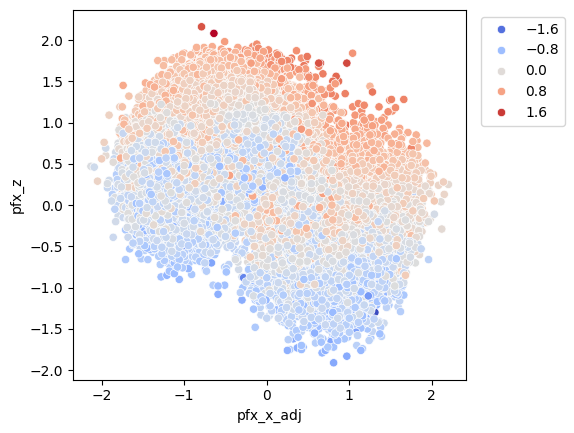

In [ ]:
hue = 'ssw_z'
x = 'pfx_x_adj'
y = 'pfx_z'
fig = sns.scatterplot(data=model_data, x=x, y=y, hue=hue, palette='coolwarm')
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
plt.show()

<IPython.core.display.Javascript object>

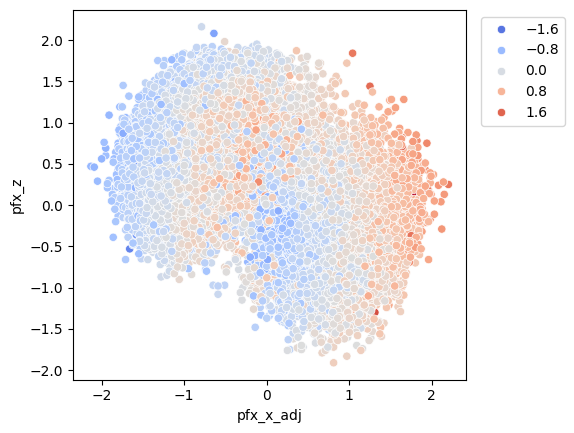

In [ ]:
hue = 'ssw_x_adj'
x = 'pfx_x_adj'
y = 'pfx_z'
fig = sns.scatterplot(data=model_data, x=x, y=y, hue=hue, palette='coolwarm')
fig.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
plt.show()

# Bat speed and swing length
Roughly going off of Powers-Yurko bat speed and swing length residual values.  

https://github.com/saberpowers/swinging-fast-and-slow/blob/main/reports/saberseminar/slides.pdf  

Using the same methods as how I calculated SSW, I'll predict bat speed and swing length for hits that are XBH (doubles, triples, and home runs). Also, I will only use bat speeds greater than 50 mph (this is a method in Powers-Yurko). Finally, I'll use some rough estimates for bat speed and swing length averages given batter/pitcher handedness and pitch type (as well as the features from Powers-Yurko regarding count and pitch location).

In [ ]:
df['xbh'] = 0
df.loc[df['outcome'].isin(['double', 'home_run', 'triple']), 'xbh'] = 1
model_data = df.loc[(df['xbh']==1) & (df['bat_speed']>50)]
_df = model_data.loc[:, ['is_lhp', 'is_lhb', 'pitch_type', 'bat_speed', 'swing_length']].groupby(['is_lhp', 'is_lhb', 'pitch_type'], as_index=False).mean()
_df = _df.rename(columns={'bat_speed':'bat_speed_avg','swing_length':'swing_length_avg'})
df = df.merge(_df, how='left')

<IPython.core.display.Javascript object>

In [ ]:
model_data.head()

<IPython.core.display.Javascript object>

,uid,pitch_type,release_speed,release_pos_x,release_pos_z,game_type,is_lhp,is_lhb,balls,strikes,...,spray_angle,bat_speed,swing_length,outcome,outcome_code,pfx_x_adj,spin_axis_adj,xbh,bat_speed_avg,swing_length_avg
6,7,SI,91.3,-1.99,6.32,R,0,1,2,2,...,-33.178809,64.11613,6.02277,double,2,-1.09,213,1,73.322739,7.101853
7,8,ST,80.6,-2.20,6.30,R,0,0,0,2,...,7.344374,70.13657,6.78443,double,2,0.81,56,1,73.095874,7.596430
12,15,CH,85.6,2.09,5.83,R,1,0,2,2,...,-29.703149,77.03158,8.02484,double,2,-1.23,242,1,74.425241,7.756618
23,30,CU,77.5,-2.15,6.36,R,0,1,2,1,...,13.749795,73.14176,7.91394,double,2,0.37,53,1,73.153308,7.591205
27,34,CU,75.2,-0.57,6.73,R,0,0,1,0,...,-26.415785,77.45640,7.96658,home_run,4,-0.13,-1,1,73.758557,7.592794


In [ ]:
model_data = df.loc[(df['xbh']==1) & (df['bat_speed']>50)]

feats = [
    'balls', 'strikes', 'plate_x', 'plate_z', 'bat_speed_avg', 'swing_length_avg'
]
targets = ['bat_speed', 'swing_length']


folds = 3
kf = KFold(folds, shuffle=True)
s1 = pd.DataFrame()
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = cb.CatBoostRegressor(verbose=False, n_estimators=300,
                               loss_function='MultiRMSE')
  model.fit(train.loc[:, feats], train[targets])
  _s = pd.DataFrame(model.predict(test.loc[:, feats]), index=test.index, columns=targets)
  s1 = pd.concat([s1,_s])

_df = df.loc[~df.index.isin(model_data.index.values), feats].dropna()
model = cb.CatBoostRegressor(verbose=False, n_estimators=300,
                             loss_function='MultiRMSE')
model.fit(model_data.loc[:, feats], model_data[targets])
s = pd.DataFrame(model.predict(_df.loc[:, feats]), index=_df.index, columns=targets)

for target,col in zip(targets, ['py_bat_speed', 'py_swing_length']):
  model_data[f'{target}_cb'] = s1[target]
  df[f'{target}_cb'] = pd.concat([model_data[f'{target}_cb'],s[target]])
  df[col] = df[target].sub(df[f"{target}_cb"])

<IPython.core.display.Javascript object>

<ipython-input-27-07e102a94cb8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[f'{target}_cb'] = s1[target]
<ipython-input-27-07e102a94cb8>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[f'{target}_cb'] = s1[target]


We can showcase trends of Powers-Yurko bat speed and swing length residuals given the count-state.

In [ ]:
_df = df.loc[:, ['balls', 'strikes', 'bat_speed', 'swing_length', 'py_bat_speed', 'py_swing_length']].groupby(['balls', 'strikes'], as_index=False).mean()
pd.pivot_table(_df, values=['bat_speed', 'swing_length', 'py_bat_speed', 'py_swing_length'], index=['balls'], columns=['strikes'])

<IPython.core.display.Javascript object>

bat_speed                       py_bat_speed                      \
strikes          0          1          2            0         1         2   
balls                                                                       
0        71.267446  70.247316  68.929130    -2.501532 -2.520837 -2.453798   
1        72.036972  71.222108  69.213873    -1.804590 -1.809740 -2.587263   
2        72.517045  71.964983  69.952433    -1.908538 -1.688607 -2.234567   
3        74.841692  73.132976  71.092530    -0.691167 -1.961980 -1.886484   

        py_swing_length                     swing_length                      
strikes               0         1         2            0         1         2  
balls                                                                         
0             -0.253291 -0.229424 -0.154209     7.187694  7.157702  7.164095  
1             -0.196115 -0.196024 -0.203842     7.253197  7.228320  7.169945  
2             -0.202938 -0.181132 -0.228970     7.229236  7.247130  7.154958  
3             -0.041364 -0.194566 -0.179168     7.443634  7.280125  7.144123

We can also further replicate study findings via ball in play outcome.

In [ ]:
df.loc[:, ['outcome', 'bat_speed', 'swing_length', 'py_bat_speed', 'py_swing_length']].groupby(['outcome'], as_index=False).mean().sort_values('py_bat_speed')

<IPython.core.display.Javascript object>

,outcome,bat_speed,swing_length,py_bat_speed,py_swing_length
3,single,70.234880,7.097151,-2.682011,-0.308695
2,out,70.510497,7.186161,-2.411064,-0.212963
4,triple,72.369195,7.216233,-0.876440,-0.159919
0,double,72.520464,7.330148,-0.803227,-0.086922
1,home_run,74.769918,7.518568,1.203747,0.143938


Further findings are potentially beneficial albeit noisier than the previous analyses. The correlation of PY bat speed and swing length is positive, however it is not clearly described when visualizing the count. This is in contrast to PY bat speed and swing length when grouped by count -- there is a clear speed and length difference from count to count. Likewise, there is a trend when plotting pitch release speed and PY swing length where faster pitches result in shorter swing lengths. While this could logically make sense (as pitch speed increases, the reaction time to a pitch decreases, favoring shorter-faster swings over longer-slower swings), the evidence doesn't seem to support this logic.

In [ ]:
df['count'] = df['balls'].astype(str).add('-').add(df['strikes'].astype(str))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

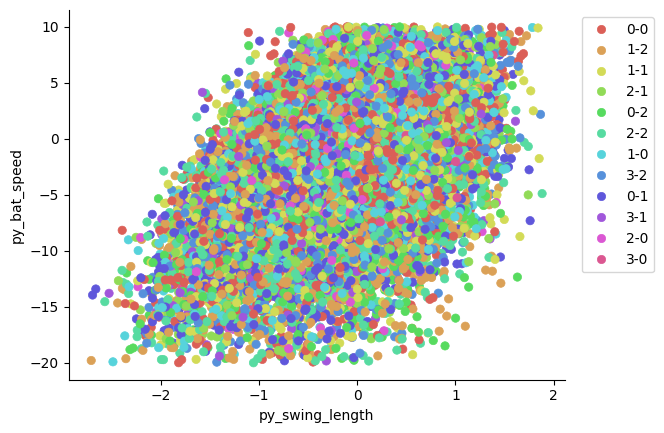

In [ ]:
_data = df.loc[(df['py_swing_length'].between(-3,2)) & (df['py_bat_speed'].between(-20,10))]
sns.scatterplot(data=_data,
                x='py_swing_length', y='py_bat_speed',
                hue='count', palette='hls',edgecolor=None)
sns.despine()
plt.legend(bbox_to_anchor=(1.02,1), loc=2)
plt.show()

<IPython.core.display.Javascript object>

<Axes: xlabel='release_speed', ylabel='py_swing_length'>

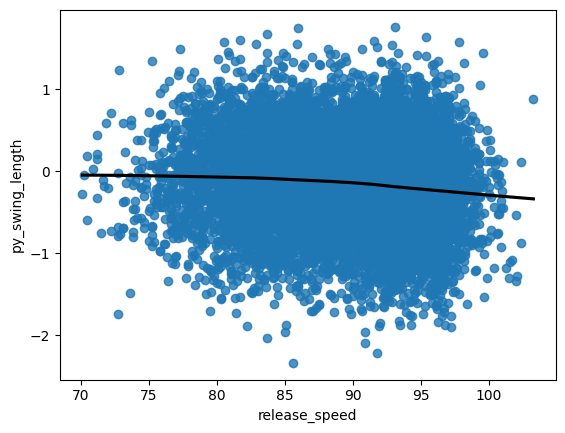

In [ ]:
sns.regplot(data=df.loc[(df['release_speed']>70) & (df['py_bat_speed'].between(-10,10))].sample(10000), x='release_speed', y='py_swing_length', lowess=True, line_kws={'color':'k'})

# Conclusions  
Feature engineering in baseball today is fairly advanced compared to previous eras of baseball analytics. While many "sabermetrics" are arithmetic and have fairly simple-to-understand forms, features derived by models like above have relatively difficult interpretations. Both types of "feature engineering" (which can simply be defined as deriving new meaning through calculating interactions) can provide better accuracy to a hit prediction model.